<a href="https://colab.research.google.com/github/LucaBarco/Homework2-Caltech101/blob/master/Copia_di_Homework2_MLDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [1]:
'''!pip3 install 'torch==1.5.0'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm' '''

"!pip3 install 'torch==1.5.0'\n!pip3 install 'torchvision==0.5.0'\n!pip3 install 'Pillow-SIMD'\n!pip3 install 'tqdm' "

**Import libraries**

In [2]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [3]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.005            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 50      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 40     # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [4]:
# Define transforms for training phase
'''train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])'''
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

#transfer learning -- 
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

**Prepare Dataset**

**Prepare Dataloaders**

In [5]:
# Clone github repository with data
! rm -r 'Caltech101'
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/LucaBarco/Homework2-Caltech101
  !mv 'Homework2-Caltech101' 'Caltech101'
DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech
# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

#train_indexes,val_indexes = train_dataset.split_training_set()
train_indexes=range(0,len(train_dataset),2)
val_indexes=range(1,len(train_dataset),2)

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)


# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 9395 (delta 17), reused 10 (delta 4), pack-reused 9366
Receiving objects: 100% (9395/9395), 129.50 MiB | 42.92 MiB/s, done.
Resolving deltas: 100% (88/88), done.
Checking out files: 100% (9155/9155), done.
train Ho contato 5784 immagini
test Ho contato 2893 immagini
Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


In [6]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [7]:
#net = alexnet() # Loading AlexNet model
net=torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True) #use alexnet

net.classifier[4] = nn.Linear(4096,1024)
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(1024, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


**Prepare Training**

In [8]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [9]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
# Start iterating over the epochs
for epoch in tqdm(range(NUM_EPOCHS)):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Step the scheduler
  scheduler.step() 

  0%|          | 0/50 [00:00<?, ?it/s]

Starting epoch 1/50, LR = [0.005]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.805107593536377


  2%|▏         | 1/50 [00:08<07:16,  8.91s/it]

Step 10, Loss 3.2388827800750732
Starting epoch 2/50, LR = [0.005]
Step 20, Loss 2.461188316345215


  4%|▍         | 2/50 [00:17<07:04,  8.85s/it]

Starting epoch 3/50, LR = [0.005]
Step 30, Loss 1.3245577812194824


  6%|▌         | 3/50 [00:26<06:56,  8.86s/it]

Starting epoch 4/50, LR = [0.005]
Step 40, Loss 0.7040000557899475


  8%|▊         | 4/50 [00:35<06:46,  8.85s/it]

Starting epoch 5/50, LR = [0.005]
Step 50, Loss 0.4656466841697693


 10%|█         | 5/50 [00:44<06:36,  8.80s/it]

Starting epoch 6/50, LR = [0.005]
Step 60, Loss 0.21565105020999908


 12%|█▏        | 6/50 [00:52<06:28,  8.84s/it]

Starting epoch 7/50, LR = [0.005]
Step 70, Loss 0.14403915405273438


 14%|█▍        | 7/50 [01:01<06:19,  8.82s/it]

Starting epoch 8/50, LR = [0.005]
Step 80, Loss 0.10690519958734512


 16%|█▌        | 8/50 [01:10<06:09,  8.81s/it]

Starting epoch 9/50, LR = [0.005]
Step 90, Loss 0.08783795684576035


 18%|█▊        | 9/50 [01:19<06:02,  8.85s/it]

Starting epoch 10/50, LR = [0.005]
Step 100, Loss 0.1104743704199791


 20%|██        | 10/50 [01:28<05:55,  8.88s/it]

Starting epoch 11/50, LR = [0.005]
Step 110, Loss 0.09158464521169662


 22%|██▏       | 11/50 [01:37<05:48,  8.94s/it]

Step 120, Loss 0.07951204478740692
Starting epoch 12/50, LR = [0.005]
Step 130, Loss 0.03705345839262009


 24%|██▍       | 12/50 [01:46<05:39,  8.93s/it]

Starting epoch 13/50, LR = [0.005]
Step 140, Loss 0.057988863438367844


 26%|██▌       | 13/50 [01:55<05:29,  8.91s/it]

Starting epoch 14/50, LR = [0.005]
Step 150, Loss 0.05838271602988243


 28%|██▊       | 14/50 [02:04<05:21,  8.94s/it]

Starting epoch 15/50, LR = [0.005]
Step 160, Loss 0.024103200063109398


 30%|███       | 15/50 [02:13<05:12,  8.93s/it]

Starting epoch 16/50, LR = [0.005]
Step 170, Loss 0.026893524453043938


 32%|███▏      | 16/50 [02:21<05:02,  8.90s/it]

Starting epoch 17/50, LR = [0.005]
Step 180, Loss 0.016192398965358734


 34%|███▍      | 17/50 [02:30<04:54,  8.91s/it]

Starting epoch 18/50, LR = [0.005]
Step 190, Loss 0.02683897875249386


 36%|███▌      | 18/50 [02:39<04:44,  8.88s/it]

Starting epoch 19/50, LR = [0.005]
Step 200, Loss 0.04025350511074066


 38%|███▊      | 19/50 [02:48<04:36,  8.91s/it]

Starting epoch 20/50, LR = [0.005]
Step 210, Loss 0.016994545236229897


 40%|████      | 20/50 [02:57<04:25,  8.86s/it]

Starting epoch 21/50, LR = [0.005]
Step 220, Loss 0.03017406538128853


 42%|████▏     | 21/50 [03:06<04:19,  8.94s/it]

Step 230, Loss 0.03158530592918396
Starting epoch 22/50, LR = [0.005]
Step 240, Loss 0.0121023990213871


 44%|████▍     | 22/50 [03:15<04:10,  8.94s/it]

Starting epoch 23/50, LR = [0.005]
Step 250, Loss 0.0043294779025018215


 46%|████▌     | 23/50 [03:24<04:02,  9.00s/it]

Starting epoch 24/50, LR = [0.005]
Step 260, Loss 0.03338058292865753


 48%|████▊     | 24/50 [03:33<03:55,  9.05s/it]

Starting epoch 25/50, LR = [0.005]
Step 270, Loss 0.00803812500089407


 50%|█████     | 25/50 [03:42<03:45,  9.01s/it]

Starting epoch 26/50, LR = [0.005]
Step 280, Loss 0.006993710529059172


 52%|█████▏    | 26/50 [03:51<03:33,  8.89s/it]

Starting epoch 27/50, LR = [0.005]
Step 290, Loss 0.03943798691034317


 54%|█████▍    | 27/50 [04:00<03:24,  8.88s/it]

Starting epoch 28/50, LR = [0.005]
Step 300, Loss 0.0023299450986087322


 56%|█████▌    | 28/50 [04:09<03:16,  8.93s/it]

Starting epoch 29/50, LR = [0.005]
Step 310, Loss 0.011106676422059536


 58%|█████▊    | 29/50 [04:18<03:07,  8.95s/it]

Starting epoch 30/50, LR = [0.005]
Step 320, Loss 0.03628423810005188


 60%|██████    | 30/50 [04:27<02:59,  8.97s/it]

Starting epoch 31/50, LR = [0.005]
Step 330, Loss 0.028906837105751038


 62%|██████▏   | 31/50 [04:36<02:51,  9.03s/it]

Step 340, Loss 0.0032850170973688364
Starting epoch 32/50, LR = [0.005]
Step 350, Loss 0.004229805897921324


 64%|██████▍   | 32/50 [04:45<02:42,  9.04s/it]

Starting epoch 33/50, LR = [0.005]
Step 360, Loss 0.008233340457081795


 66%|██████▌   | 33/50 [04:54<02:31,  8.93s/it]

Starting epoch 34/50, LR = [0.005]
Step 370, Loss 0.0050634234212338924


 68%|██████▊   | 34/50 [05:03<02:23,  8.95s/it]

Starting epoch 35/50, LR = [0.005]
Step 380, Loss 0.008237487636506557


 70%|███████   | 35/50 [05:12<02:14,  8.95s/it]

Starting epoch 36/50, LR = [0.005]
Step 390, Loss 0.005844175349920988


 72%|███████▏  | 36/50 [05:20<02:04,  8.92s/it]

Starting epoch 37/50, LR = [0.005]
Step 400, Loss 0.0165421012789011


 74%|███████▍  | 37/50 [05:29<01:56,  8.94s/it]

Starting epoch 38/50, LR = [0.005]
Step 410, Loss 0.01286202110350132


 76%|███████▌  | 38/50 [05:39<01:47,  8.99s/it]

Starting epoch 39/50, LR = [0.005]
Step 420, Loss 0.003254617564380169


 78%|███████▊  | 39/50 [05:48<01:39,  9.00s/it]

Starting epoch 40/50, LR = [0.005]
Step 430, Loss 0.03292924910783768


 80%|████████  | 40/50 [05:57<01:30,  9.04s/it]

Starting epoch 41/50, LR = [5e-05]
Step 440, Loss 0.005386618431657553


 82%|████████▏ | 41/50 [06:06<01:22,  9.11s/it]

Step 450, Loss 0.0050041563808918
Starting epoch 42/50, LR = [0.0005]
Step 460, Loss 0.006417652126401663


 84%|████████▍ | 42/50 [06:15<01:12,  9.10s/it]

Starting epoch 43/50, LR = [0.0005]
Step 470, Loss 0.005203127861022949


 86%|████████▌ | 43/50 [06:24<01:03,  9.01s/it]

Starting epoch 44/50, LR = [0.0005]
Step 480, Loss 0.003230378497391939


 88%|████████▊ | 44/50 [06:33<00:54,  9.04s/it]

Starting epoch 45/50, LR = [0.0005]
Step 490, Loss 0.001905923942103982


 90%|█████████ | 45/50 [06:42<00:45,  9.04s/it]

Starting epoch 46/50, LR = [0.0005]
Step 500, Loss 0.001828164211474359


 92%|█████████▏| 46/50 [06:51<00:36,  9.04s/it]

Starting epoch 47/50, LR = [0.0005]
Step 510, Loss 0.0034060911275446415


 94%|█████████▍| 47/50 [07:00<00:27,  9.03s/it]

Starting epoch 48/50, LR = [0.0005]
Step 520, Loss 0.0010587774449959397


 96%|█████████▌| 48/50 [07:09<00:18,  9.04s/it]

Starting epoch 49/50, LR = [0.0005]
Step 530, Loss 0.006907308474183083


 98%|█████████▊| 49/50 [07:18<00:09,  9.04s/it]

Starting epoch 50/50, LR = [0.0005]
Step 540, Loss 0.001880232011899352


100%|██████████| 50/50 [07:27<00:00,  8.96s/it]


**Validation**

In [10]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
print(str(len(val_dataloader)))
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy))

  0%|          | 0/12 [00:00<?, ?it/s]

12


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]

Validation Accuracy: 0.8775933609958506


**Test**

In [11]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:08<00:00,  1.41it/s]

Test Accuracy: 0.8212927756653993


['accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'Faces', 'Faces_easy', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'Leopards', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'Motorbikes', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', 'stapler

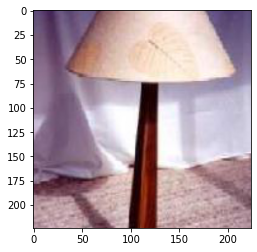

			lamp


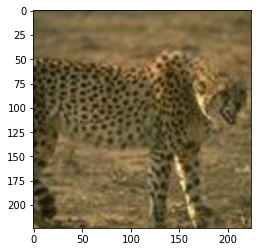

			Leopards


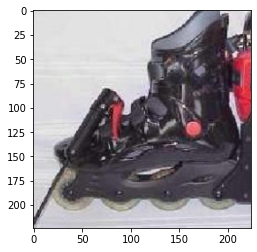

			inline_skate


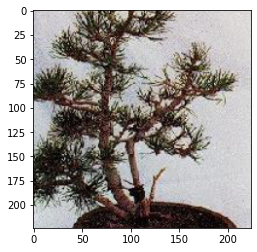

			bonsai


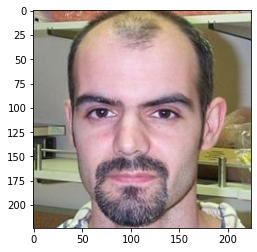

			Faces_easy


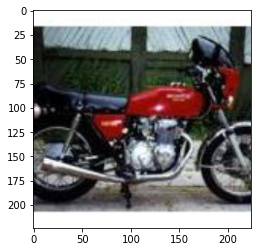

			Motorbikes


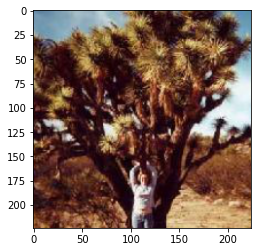

			joshua_tree


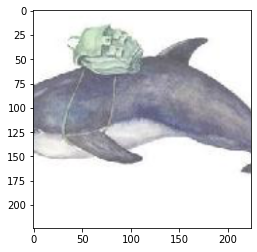

			dolphin


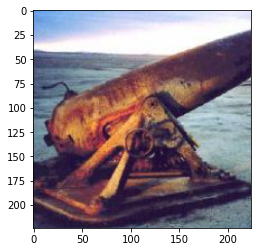

			crayfish


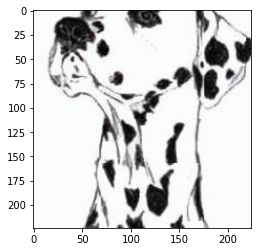

			dalmatian


In [14]:
import matplotlib.pyplot as plt
import random 
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

labels=list(test_dataset.return_labels())
print (labels)
#Get some random training images
for i in range(0,10):
  index=len(test_dataset)-1
  image,label=test_dataset[random.randint(0,index)]
  imagex = image.unsqueeze(0)
  imageCuda=imagex.to(DEVICE)
  outputs = net(imageCuda)
  preds = torch.max(outputs.data, 1)
  imshow(image)
  print( "\t\t\t"+labels[preds.indices.cpu().numpy()[0]])